In [1]:
import sys
sys.path.append('../')  

from data.dummy_datasets import *
from utils.operations import E2G
from models.gnca import GNCAModel
from utils.plots import *
from utils.operations import *
import torch
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
from tqdm import tqdm
import matplotlib.animation as animation
import math
from utils.sample_pool import SamplePool

In [2]:
EPOCHS = 1000
POOL_SIZE = 1024
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8  # number of states batched at each pool sample call
USE_PATTERN_POOL =  True

In [22]:
length = 7

coords, E = create_cubic_canvas(length, 1)
G = E2G(E, int(math.pow(length, 3)))
adj = nx.adjacency_matrix(G).toarray()

seed = np.zeros(coords.shape[0])
seed[coords.shape[0] // 2] = 1
seed_ = np.zeros(coords.shape[0]) # second column of arbitrary attributes
seed = np.stack((seed, seed_), axis=-1)

_target = create_wall_mask(length, 2)

adj = torch.tensor(adj, dtype=torch.float32).to(DEVICE)
seed = torch.tensor(seed, dtype=torch.float32).to(DEVICE)
target = torch.tensor(_target, dtype=torch.float32).to(DEVICE)

if USE_PATTERN_POOL:
    target = target.unsqueeze(0).expand(BATCH_SIZE, -1)

In [10]:
gnca = GNCAModel(input_dim=4, channel_n=2, fire_rate=0.5, device=DEVICE)
optimizerG = optim.Adam(gnca.parameters(), lr=2e-3)
pool = SamplePool(x=seed.repeat(POOL_SIZE, 1, 1))
# torch.nn.utils.clip_grad_norm_(gnca.parameters(), max_norm=1.0) # gradient clipping

AttributeError: 'numpy.ndarray' object has no attribute 'to'

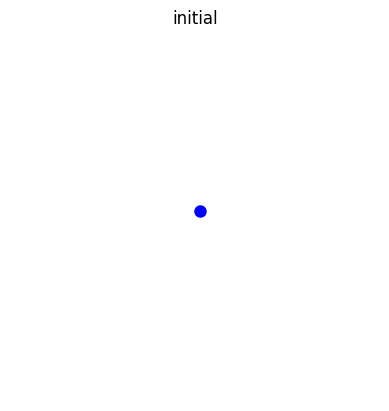

In [11]:
plot_3d_G(G, coords, "initial", transparent=True, show_edges=True, angle=30, node_alpha=seed[:, 0].to('cpu').detach().numpy())
plot_3d_G(G, coords, "target", transparent=True, show_edges=False, angle=30, node_alpha=_target.to('cpu').detach().numpy())

Training

In [25]:
alphas = []
losses = []

gnca.train()

def loss_f(yhat, y):
    print(yhat.shape, y.shape)
    return F.mse_loss(yhat, y)

def train_step(x):
    iter_n = np.random.randint(64, 96)
    for i in range(iter_n):
        x = gnca(x, adj)  
    loss = loss_f(x[:, :, 0], target)
    optimizerG.zero_grad()
    loss.backward()
    optimizerG.step()
    return x, loss

# Training loop
with tqdm(total=EPOCHS, desc="Training Progress") as pbar:
    for epoch in range(EPOCHS):
        
        if USE_PATTERN_POOL:
            batch = pool.sample(BATCH_SIZE)
            x0 = batch.x
            loss_rank = loss_f(x0[:, :, 0], target).cpu().numpy().argsort()[::-1]
            x0 = x0[loss_rank]
            x0[:1] = seed
        else:
            x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
        
        x, loss = train_step(x0)
        
        if USE_PATTERN_POOL:
            batch.x[:] = x
            batch.commit()

        losses.append(loss.item())

        # # gradient clipping
        # for param in gnca.parameters():
        #     if param.grad is not None:
        #         param.grad.data /= (torch.norm(param.grad.data) + 1e-8)

        # figure out how to display entire batch
        if (epoch % 10 == 0):
            alphas.append(x[:, 0].to('cpu').detach().numpy())

        # Update progress bar description
        pbar.set_postfix({'Loss': loss.item()})
        pbar.update(1)  # Move progress bar forward

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([8, 343]) torch.Size([8, 343])


ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 

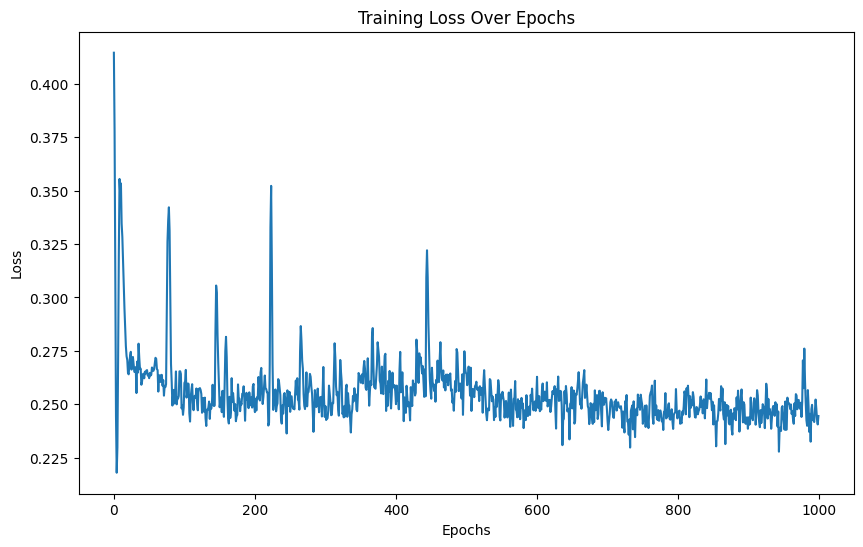

<Axes3D: title={'center': 'last generation'}>

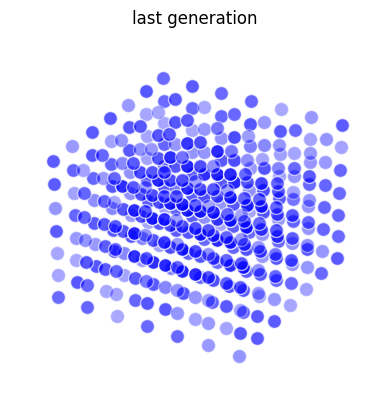

In [7]:
plot_loss(losses, EPOCHS)
plot_3d_G(G, coords, "last generation", transparent=True, show_edges=False, angle=30, node_alpha=alphas[-1])

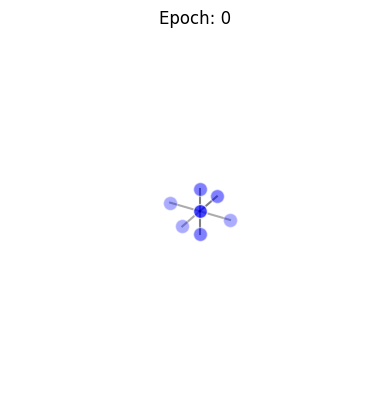

In [8]:
# Create the figure and 3D axis
fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111, projection='3d')


# Define the update function for the animation
def update(i):
    ax.clear() 
    node_alpha = np.clip(alphas[i], 0, 1)
    plot_3d_G(G, coords, "cube G", transparent=True, show_edges=True, angle=30, node_alpha=node_alpha, ax=ax)
    ax.set_title(f"Epoch: {i*1}")
    return ax,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(alphas), interval=500, repeat=False)

ani.save('life.gif', dpi=300, writer=animation.PillowWriter(fps=2))